In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define paths
base_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
val_path = os.path.join(base_path, 'validation')

# Get class names from folder names
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

# Parameters for feature extraction
img_size = (224, 224)  # Original size
target_size = (64, 64)  # Resize for faster processing

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Compute histogram for each channel
    hist_h = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])
    # Normalize histograms
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()
    # Concatenate histograms
    color_hist = np.hstack([hist_h, hist_s, hist_v])
    return color_hist

def extract_hog_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute HOG features
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), transform_sqrt=True, 
                      block_norm="L2-Hys", visualize=True)
    return features

def extract_lbp_features(image, radius=3, n_points=24):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute LBP features
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    # Compute histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), 
                          range=(0, n_points + 2))
    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_all_features(image):
    # Resize image
    image = cv2.resize(image, target_size)
    
    # Extract features
    color_hist = extract_color_histogram(image)
    hog_features = extract_hog_features(image)
    lbp_features = extract_lbp_features(image)
    
    # Combine all features
    all_features = np.hstack([color_hist, hog_features, lbp_features])
    return all_features

In [4]:
def load_data_with_features(data_path):
    features = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)
        
        for image_file in tqdm(image_files, desc=f"Processing {class_name}"):
            image_path = os.path.join(class_path, image_file)
            
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                continue
                
            # Extract features
            image_features = extract_all_features(image)
            
            features.append(image_features)
            labels.append(class_idx)
    
    return np.array(features), np.array(labels)

# Load training data with features
print("Loading training data...")
X_train, y_train = load_data_with_features(train_path)

# Load validation data with features
print("\nLoading validation data...")
X_val, y_val = load_data_with_features(val_path)

# Load test data with features
print("\nLoading test data...")
X_test, y_test = load_data_with_features(test_path)

Loading training data...


Processing Tomato: 100%|██████████| 1000/1000 [00:16<00:00, 58.87it/s]



Loading validation data...


Processing Tomato: 100%|██████████| 200/200 [00:03<00:00, 56.95it/s]



Loading test data...


Processing Tomato: 100%|██████████| 200/200 [00:03<00:00, 59.13it/s]


In [5]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [6]:
print("Training SVM classifier...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
val_preds = svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy (SVM): {val_accuracy:.4f}")

# Evaluate on test set
test_preds = svm_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy (SVM): {test_accuracy:.4f}")

# Classification report
print("\nClassification Report (SVM):")
print(classification_report(y_test, test_preds, target_names=class_names))

Training SVM classifier...
Validation Accuracy (SVM): 0.9400
Test Accuracy (SVM): 0.9503

Classification Report (SVM):
              precision    recall  f1-score   support

        Bean       0.94      0.95      0.95       200
Bitter_Gourd       0.97      0.97      0.97       200
Bottle_Gourd       0.98      0.99      0.98       200
     Brinjal       0.94      0.94      0.94       200
    Broccoli       0.91      0.95      0.93       200
     Cabbage       0.91      0.93      0.92       200
    Capsicum       0.95      0.98      0.97       200
      Carrot       0.98      0.94      0.96       200
 Cauliflower       0.91      0.93      0.92       200
    Cucumber       0.97      0.93      0.95       200
      Papaya       0.98      0.96      0.97       200
      Potato       0.96      0.99      0.98       200
     Pumpkin       0.94      0.89      0.92       200
      Radish       0.97      0.97      0.97       200
      Tomato       0.96      0.93      0.94       200

    accuracy   

Test Accuracy: 0.9503

Classification Report:
              precision    recall  f1-score   support

        Bean       0.94      0.95      0.95       200
Bitter_Gourd       0.97      0.97      0.97       200
Bottle_Gourd       0.98      0.99      0.98       200
     Brinjal       0.94      0.94      0.94       200
    Broccoli       0.91      0.95      0.93       200
     Cabbage       0.91      0.93      0.92       200
    Capsicum       0.95      0.98      0.97       200
      Carrot       0.98      0.94      0.96       200
 Cauliflower       0.91      0.93      0.92       200
    Cucumber       0.97      0.93      0.95       200
      Papaya       0.98      0.96      0.97       200
      Potato       0.96      0.99      0.98       200
     Pumpkin       0.94      0.89      0.92       200
      Radish       0.97      0.97      0.97       200
      Tomato       0.96      0.93      0.94       200

    accuracy                           0.95      3000
   macro avg       0.95      0.95 

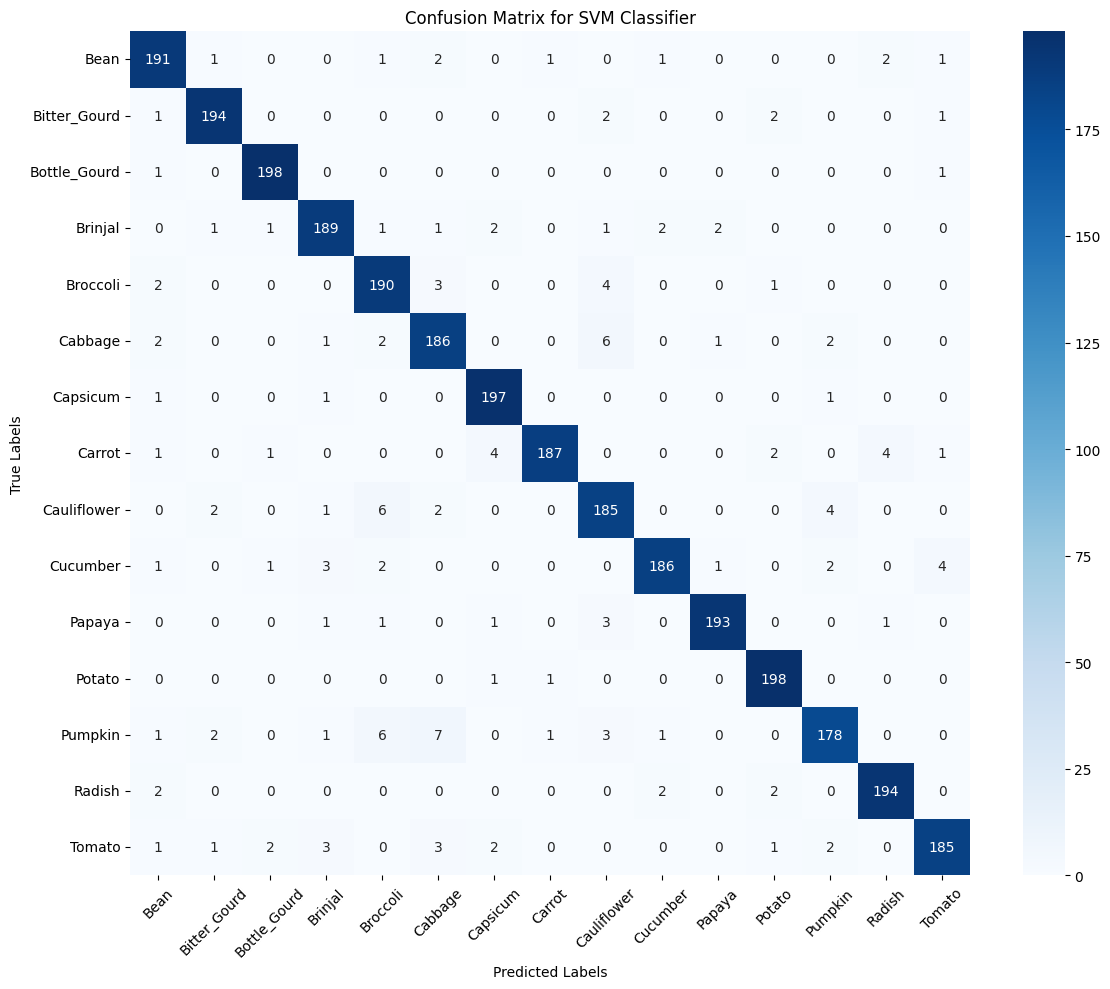

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test set
test_preds = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, test_preds, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# Step 9: Save Models and Results (Corrected Version)
import joblib
import pandas as pd

# Save only the models we've actually trained
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save results to CSV (only SVM results since that's what we trained)
results = {
    'Model': ['SVM'],
    'Validation Accuracy': [val_accuracy],
    'Test Accuracy': [test_accuracy]
}
results_df = pd.DataFrame(results)
results_df.to_csv('handcrafted_results.csv', index=False)

print("Models and results saved successfully!")
print("Saved files:")
print("- svm_model.pkl")
print("- feature_scaler.pkl")
print("- handcrafted_results.csv")

Models and results saved successfully!
Saved files:
- svm_model.pkl
- feature_scaler.pkl
- handcrafted_results.csv


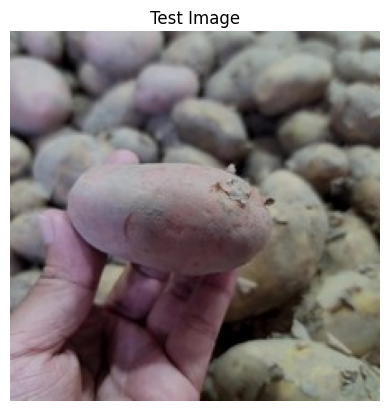

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [16]:
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Load saved models
svm_model = joblib.load('/kaggle/working/svm_model.pkl')
scaler = joblib.load('/kaggle/working/feature_scaler.pkl')

# Path to test image
image_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Potato/0015.jpg'

# Load and display image
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not read image at {image_path}")
else:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Test Image')
    plt.show()
    
    # Extract features
    features = extract_all_features(image)
    features_scaled = scaler.transform([features])
    
    # Make prediction
    prediction = svm_model.predict(features_scaled)
    prediction_prob = svm_model.predict_proba(features_scaled)
    
    # Display results
    print(f"\nPredicted Class: {class_names[prediction[0]]}")
    print("\nPrediction Probabilities:")
    for i, prob in enumerate(prediction_prob[0]):
        print(f"{class_names[i]}: {prob:.4f}")